<a href="https://colab.research.google.com/github/jonrtaylor/twitch/blob/master/twitchtorial_part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np

TRAINING_DATAPATH = 'https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz'
TOURNAMENT_DATAPATH = 'https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz'

df_train = pd.read_csv(TRAINING_DATAPATH)
df_tournament = pd.read_csv(TOURNAMENT_DATAPATH)

In [20]:
from collections import Counter
import re

# Feature columns
features = df_train.columns[df_train.columns.str.startswith('feature')]

groupCount = Counter()
for feature in features:
    _, group_n = feature.split('_')
    group, n = re.split(r'\d+', group_n)
    groupCount[group] += 1
groupCount

Counter({'charisma': 86,
         'constitution': 114,
         'dexterity': 14,
         'intelligence': 12,
         'strength': 38,
         'wisdom': 46})

,Observations
count,120.000000
mean,4181.733333
std,583.884482
min,2371.000000
25%,3929.250000
50%,4388.500000
75%,4582.750000
max,4893.000000


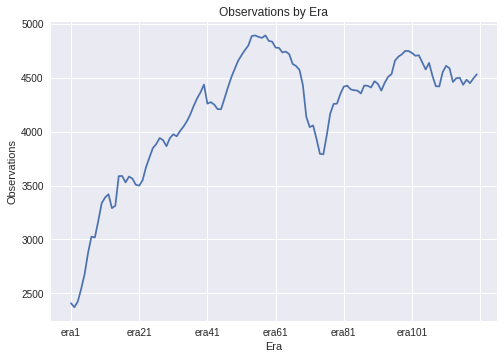

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
eraCount = Counter()
for era in df_train['era']:
    eraCount[era] += 1
eraCount = pd.DataFrame.from_dict(eraCount, orient='index', columns=['Observations'])
eraCount.plot(legend=None)
plt.xlabel('Era')
plt.ylabel('Observations')
plt.title('Observations by Era')
eraCount.describe()

In [22]:
df_train[features].describe()

,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,feature_charisma27,feature_charisma28,...,feature_wisdom7,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46
count,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,...,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000
mean,0.499981,0.499979,0.499979,0.499981,0.499977,0.499977,0.499977,0.499981,0.499980,0.499980,0.499981,0.499977,0.499968,0.499976,0.499974,0.499977,0.499976,0.499971,0.499974,0.499974,0.499986,0.499977,0.499979,0.499980,0.499977,0.499972,0.499974,0.499977,0.499977,0.499974,0.499968,0.499981,0.499983,0.499979,0.499977,0.499976,0.499982,0.499981,0.499976,0.499976,...,0.499975,0.499982,0.499973,0.499969,0.499976,0.499971,0.499978,0.499981,0.499979,0.499979,0.499981,0.499969,0.499969,0.499981,0.499974,0.499973,0.499976,0.499974,0.499969,0.499982,0.499979,0.499974,0.499981,0.499979,0.499979,0.499976,0.499974,0.499978,0.499981,0.499982,0.499979,0.499982,0.499982,0.499974,0.499980,0.499982,0.499980,0.499974,0.499979,0.499971
std,0.353596,0.353593,0.353593,0.353596,0.353587,0.353587,0.353587,0.353596,0.352099,0.352099,0.353596,0.353587,0.352986,0.334986,0.337437,0.338557,0.313514,0.353014,0.320992,0.291361,0.353473,0.348416,0.343023,0.343407,0.340066,0.336707,0.291361,0.337442,0.338557,0.353060,0.352986,0.343146,0.341998,0.288122,0.333733,0.334986,0.265371,0.339712,0.288295,0.344535,...,0.352542,0.350824,0.353485,0.349533,0.332947,0.353419,0.344672,0.353596,0.353143,0.347689,0.353596,0.351413,0.349533,0.353596,0.348778,0.353485,0.302390,0.341651,0.351413,0.350824,0.353143,0.348778,0.353596,0.347689,0.352772,0.302390,0.341651,0.344672,0.353596,0.352151,0.352772,0.353139,0.353139,0.35

In [23]:
# Target column
target = df_train.columns[df_train.columns.str.startswith('target')]

df_train[target].describe()

,target_kazutsugi
count,501808.000000
mean,0.500002
std,0.352994
min,0.000000
25%,0.250000
50%,0.500000
75%,0.750000
max,1.000000


In [24]:
# Number of observations per target value
df_train[target].apply(lambda x: x.value_counts())

,target_kazutsugi
0.50,101632
1.00,100047
0.25,100046
0.00,100042
0.75,100041


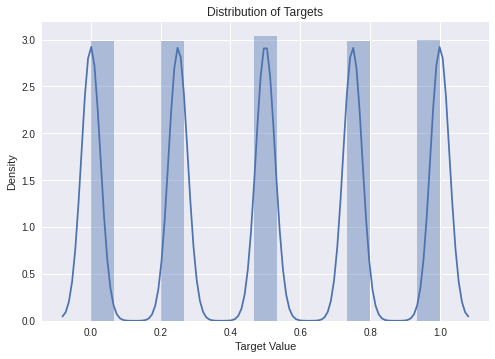

In [25]:
# Distribution of target values
sns.distplot(df_train[target], hist=True, kde=True, bins=15)
plt.xlabel('Target Value')
plt.ylabel('Density')
plt.title('Distribution of Targets')
plt.show()

In [26]:
df_train[features] = df_train[features].astype(np.float16)
df_train[target] = df_train[target].astype(np.float16)

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501808 entries, 0 to 501807
Columns: 314 entries, id to target_kazutsugi
dtypes: float16(311), object(3)
memory usage: 309.2+ MB


In [28]:
df_tournament.info()

# Counts of different data types
df_tournament['data_type'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1632911 entries, 0 to 1632910
Columns: 314 entries, id to target_kazutsugi
dtypes: float64(311), object(3)
memory usage: 3.8+ GB


test          1520846
validation     106895
live             5170
Name: data_type, dtype: int64

In [29]:
df_tournament[features] = df_tournament[features].astype(np.float16)

In [30]:
df_tournament.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1632911 entries, 0 to 1632910
Columns: 314 entries, id to target_kazutsugi
dtypes: float16(310), float64(1), object(3)
memory usage: 1015.3+ MB


In [31]:
df_tournament.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target_kazutsugi
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,0.25,0.50,0.5,0.25,0.0,0.25,0.50,0.25,0.00,0.25,1.00,1.00,0.25,1.00,1.00,0.25,0.25,0.0,0.50,0.25,0.75,0.00,0.50,0.25,0.25,0.25,0.50,0.00,0.50,1.00,...,0.00,0.0,0.25,0.5,0.25,0.25,0.00,0.25,0.00,0.25,0.50,0.50,0.50,0.50,0.00,0.25,0.75,0.25,0.25,0.50,0.25,0.00,0.25,0.50,0.25,0.5,0.25,0.25,1.00,0.75,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.00
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,0.75,0.25,0.0,0.75,0.5,0.00,0.25,0.50,0.00,1.00,0.25,0.25,1.00,1.00,0.25,0.75,0.00,0.0,0.75,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.00,1.00,...,0.50,0.5,0.25,1.0,0.50,0.25,0.00,0.25,0.50,0.25,1.00,0.25,0.00,0.50,0.75,0.75,0.50,1.00,1.00,0.25,0.50,0.25,0.50,0.50,0.50,0.5,0.25,0.25,0.75,0.50,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.25
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,1.00,0.50,0.5,1.00,1.0,1.00,0.75,0.50,0.50,1.00,1.00,0.50,0.50,0.00,1.00,0.50,1.00,0.5,1.00,0.50,1.00,0.25,1.00,1.00,1.00,0.50,1.00,1.00,0.75,1.00,...,0.25,0.5,0.00,0.0,0.00,0.25,0.25,0.00,0.50,0.00,0.00,0.00,0.25,0.00,0.25,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.75,0.0,0.00,0.25,0.00,0.00,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,0.50,0.75,1.0,0.75,0.0,0.50,0.00,0.50,0.75,0.50,0.75,0.25,0.75,0.25,0.75,0.25,0.75,1.0,0.50,0.50,0.75,0.50,1.00,0.50,0.25,0.75,0.25,0.75,0.25,0.75,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.25,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.75,0.00,0.00,0.25,0.25,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.75
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,0.25,0.25,0.5,0.50,1.0,1.00,1.00,1.00,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.00,0.25,0.0,0.00,0.75,0.25,1.00,0.25,1.00,0.75,0.00,1.00,0.75,0.75,0.75,...,0.00,0.5,0.50,0.0,0.75,0.50,0.75,0.25,0.25,0.25,0.00,0.25,0.50,0.25,1.00,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.75,1.00,1.0,0.75,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,1.00


In [32]:
df_train["erano"] = df_train.era.str.slice(3).astype(int)
eras = df_train.erano
target = "target_kazutsugi"

In [45]:
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [34]:
feature_corrs = df_train[features].corr()

In [35]:
feature_corrs.stack().head()

feature_intelligence1  feature_intelligence1    1.000000
                       feature_intelligence2   -0.014157
                       feature_intelligence3   -0.024404
                       feature_intelligence4    0.652596
                       feature_intelligence5    0.069868
dtype: float64

In [36]:
tdf = feature_corrs.stack()
tdf = tdf[tdf.index.get_level_values(0) < tdf.index.get_level_values(1)]
tdf.sort_values()

feature_constitution112  feature_constitution9    -0.855008
feature_constitution33   feature_constitution46   -0.830310
feature_constitution112  feature_constitution60   -0.820694
feature_constitution46   feature_constitution87   -0.815888
feature_constitution112  feature_constitution33   -0.759084
                                                     ...   
feature_constitution27   feature_constitution7     0.948920
feature_constitution13   feature_constitution79    0.949139
feature_wisdom31         feature_wisdom39          0.954984
feature_wisdom46         feature_wisdom7           0.963706
feature_wisdom12         feature_wisdom2           0.968062
Length: 47895, dtype: float64

In [38]:
df1 = df_train[eras<=eras.median()]
df2 = df_train[eras>eras.median()]

In [39]:
corr1 = df1[features].corr().unstack()
corr1 = corr1[corr1.index.get_level_values(0) < corr1.index.get_level_values(1)]

In [40]:
corr2 = df2[features].corr().unstack()
corr2 = corr2[corr2.index.get_level_values(0) < corr2.index.get_level_values(1)]

In [42]:
tdf = pd.DataFrame({
    "corr1": corr1,
    "corr2": corr2,
})
tdf["corr_diff"] = tdf.corr2 - tdf.corr1
tdf.sort_values(by="corr_diff")

corr1     corr2  corr_diff
feature_intelligence11 feature_intelligence9   0.091352 -0.128851  -0.220203
feature_dexterity12    feature_intelligence10  0.548931  0.343117  -0.205814
feature_dexterity9     feature_intelligence11  0.078715 -0.127070  -0.205785
feature_dexterity1     feature_dexterity12     0.653528  0.447942  -0.205587
feature_intelligence10 feature_intelligence11  0.075022 -0.130511  -0.205534
...                                                 ...       ...        ...
feature_intelligence8  feature_wisdom22       -0.088346  0.117772   0.206119
feature_intelligence4  feature_wisdom43       -0.102438  0.103758   0.206197
                       feature_wisdom33       -0.078930  0.133664   0.212593
feature_intelligence8  feature_wisdom43       -0.121306  0.115194   0.236501
                       feature_wisdom33       -0.091759  0.150549   0.242308

[47895 rows x 3 columns]

In [46]:
feature_scores = {
    feature: numerai_score(df_train[target], df_train[feature])
    for feature in features
}

In [47]:
pd.Series(feature_scores).sort_values()

feature_dexterity7    -0.014545
feature_dexterity4    -0.013817
feature_dexterity6    -0.013403
feature_dexterity11   -0.012352
feature_dexterity14   -0.010608
                         ...   
feature_charisma6      0.011300
feature_strength14     0.011317
feature_strength4      0.011407
feature_charisma54     0.011528
feature_strength34     0.012132
Length: 310, dtype: float64

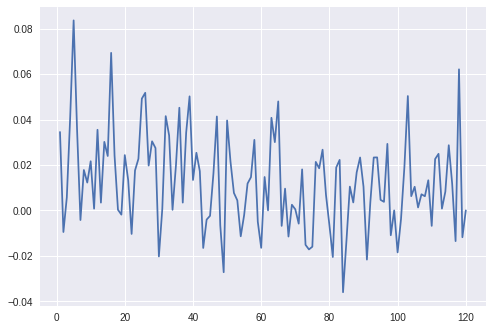

In [49]:
# Single features do not work consistently though
by_era_correlation = pd.Series({
    era: np.corrcoef(tdf[target], tdf["feature_strength34"])[0,1]
    for era, tdf in df_train.groupby(eras)
})
by_era_correlation.plot()

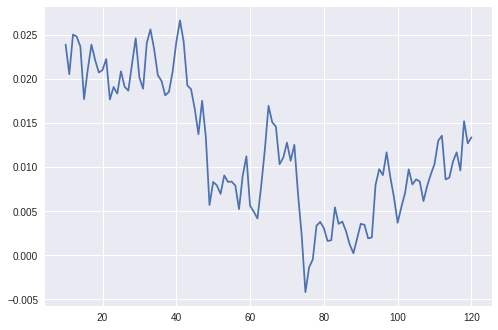

In [50]:
# With a rolling 10 era average you can see some trends
by_era_correlation.rolling(10).mean().plot()

In [52]:
df1 = df_train[eras<=eras.median()]
df2 = df_train[eras>eras.median()]

In [53]:
import sklearn
from sklearn import linear_model

linear1 = linear_model.LinearRegression()
linear1.fit(df1[features], df1[target])
linear2 = linear_model.LinearRegression()
linear2.fit(df2[features], df2[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [54]:
r2 = [
    [
        model.score(dfX[features], dfX[target])
        for dfX in [df1, df2]
    ]
    for model in [linear1, linear2]
]
pd.DataFrame(r2, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.004451,-0.000319
train_on_2,0.000597,0.003601


In [55]:
# Note in particular that the correlation of (train_on_1, eval_on_2) is quite decent
corrs = [
    [
        numerai_score(dfX[target], pd.Series(model.predict(dfX[features]), index=dfX.index))
        for dfX in [df1, df2]
    ]
    for model in [linear1, linear2]
]
pd.DataFrame(corrs, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.065886,0.030998
train_on_2,0.034797,0.058598


In [57]:
# Train a standard logistic regression as a classifier
logistic = linear_model.LogisticRegression()
logistic.fit(df_train[features], (df_train[target]*4).astype(int))
logistic.score(df_train[features], (df_train[target]*4).astype(int))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.2620902815419443

array([[ 1.        , -0.89871625, -0.9379054 , -0.95824084,  0.87658851],
       [-0.89871625,  1.        ,  0.90616807,  0.87605387, -0.95879302],
       [-0.9379054 ,  0.90616807,  1.        ,  0.87984847, -0.95387591],
       [-0.95824084,  0.87605387,  0.87984847,  1.        , -0.87607131],
       [ 0.87658851, -0.95879302, -0.95387591, -0.87607131,  1.        ]])

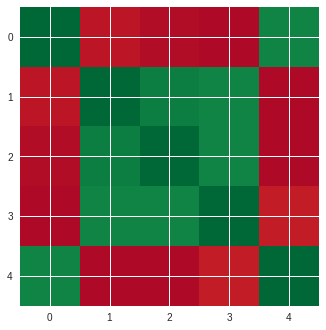

In [58]:
# The first and last class are highly correlated
corrs=np.corrcoef(logistic.predict_proba(df_train[features]).T)
plt.imshow(corrs, vmin=-1, vmax=1, cmap="RdYlGn")
corrs

In [59]:
# In-sample correlation is 5.4%
preds = pd.Series(logistic.predict_proba(df_train[features]).dot(logistic.classes_), index=df_train.index)
numerai_score(df_train[target], preds)

0.05293582717755428

In [62]:
# A standard linear model has a slightly higher correlation
linear = linear_model.LinearRegression()
linear.fit(df_train[features], df_train[target])
linear.score(df_train[features], df_train[target])
preds = pd.Series(linear.predict(df_train[features]), index=df_train.index)
numerai_score(df_train[target], preds)

0.05419354929269541

In [63]:
from sklearn import model_selection

crossvalidators = [
    model_selection.KFold(5),
    model_selection.KFold(5, shuffle=True),
    model_selection.GroupKFold(5),
    model_selection.TimeSeriesSplit(5)
]

In [64]:
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [67]:
from sklearn import metrics
for cv in crossvalidators:
    print(cv)
    print(np.mean(
            model_selection.cross_val_score(
            linear_model.LinearRegression(),
            df_train[features],
            df_train[target],
            cv=cv,
            n_jobs=1,
            groups=eras,
            scoring=metrics.make_scorer(correlation_score, greater_is_better=True)
        )))
    print()

KFold(n_splits=5, random_state=None, shuffle=False)
0.03658489211607555

KFold(n_splits=5, random_state=None, shuffle=True)
0.04353921706900492

GroupKFold(n_splits=5)
0.03806986524081245

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.03394404633146867



In [68]:
eras10 = (eras // 10) * 10
eras10.value_counts()

50     48186
60     46831
100    46107
90     45609
110    45070
80     43971
40     43439
30     41101
70     40403
20     37444
10     34600
0      24515
120     4532
Name: erano, dtype: int64

In [69]:
results10 = []
for train_era, tdf in df_train[eras10<120].groupby(eras10):
    print(train_era)
    model = linear_model.LinearRegression()
    model.fit(tdf[features], tdf[target])
    for test_era, tdf in df_train[eras10<120].groupby(eras10):
        results10.append([
            train_era,
            test_era,
            correlation_score(tdf[target], model.predict(tdf[features]))
        ])

0
10
20
30
40
50
60
70
80
90
100
110


In [70]:
results_df = pd.DataFrame(
    results10,
    columns=["train_era", "test_era", "score"]
).pivot(index="train_era", columns="test_era", values="score")
results_df

test_era,0,10,20,30,40,50,60,70,80,90,100,110
train_era,,,,,,,,,,,,
0,0.146423,0.036964,0.038011,0.034265,0.025910,0.009745,0.002874,0.037816,0.029892,0.033867,0.019427,0.004163
10,0.042831,0.119715,0.034830,0.033846,0.035863,0.003364,0.006552,0.033276,0.034233,0.038309,0.023926,0.014590
20,0.043862,0.040213,0.123154,0.036627,0.023993,0.009394,0.000732,0.027858,0.016508,0.035827,0.021159,0.007964
30,0.043145,0.040596,0.043468,0.108705,0.037635,0.023734,0.007650,0.046880,0.023781,0.039757,0.010581,0.010506
40,0.039806,0.044743,0.029963,0.037634,0.098834,0.014143,0.007886,0.035909,0.028617,0.031637,0.008431,0.019615
50,0.017756,0.006481,0.011675,0.025233,0.014928,0.106223,0.009696,0.017742,0.002873,0.018168,0.014381,0.016401
60,0.011671,0.016350,0.006663,0.009488,0.009990,0.009639,0.104522,0.017671,0.006228,0.003792,0.004541,0.010718
70,0.039278,0.036965,0.028348,0.034946,0.025443,0.006190,0.010160,0.129820,0.032531,0.035526,0.019330,0.008851
80,0.038294,0.038707,0.017229,0.020259,0.021633,0.000531,0.003182,0.034221,0.108331,0.030059,0.017398,0.006075


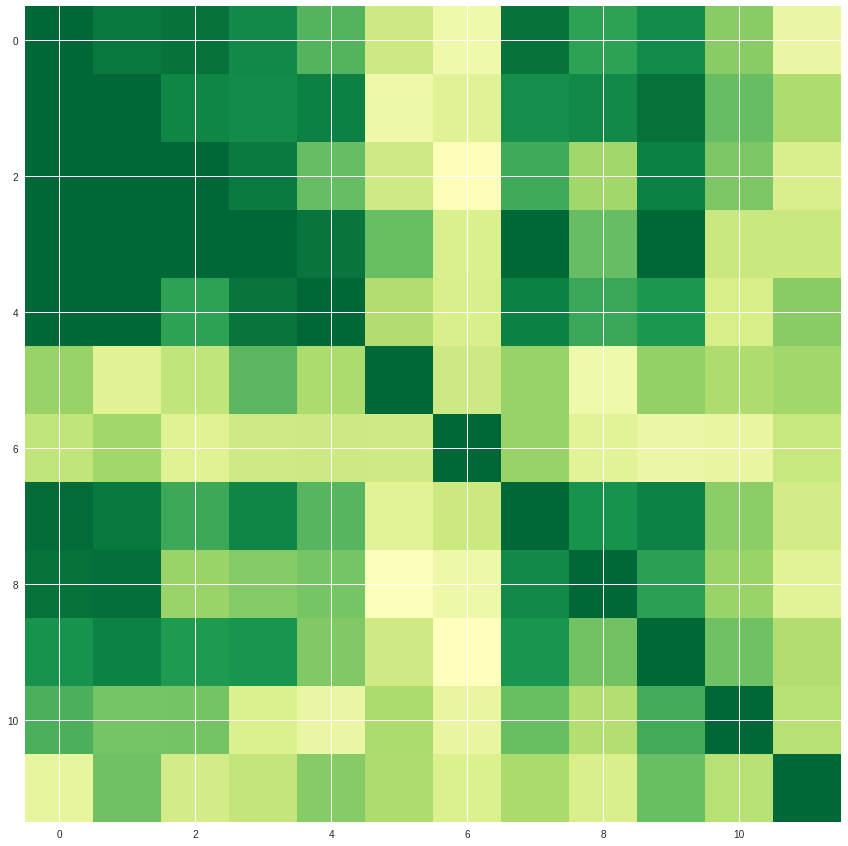

In [71]:
# Each row here is the training block of eras, each column is a testing block of eras.
# Note that there is a period in the middle that does not seem to be relevant to other eras, and the
#  overall performance seems to decrease a bit over time.
plt.figure(figsize=(15,15))
plt.imshow(results_df, vmin=-0.04, vmax=0.04, cmap="RdYlGn")